In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from sklearn.metrics.cluster import adjusted_rand_score as ari

In [2]:
def nett_customers():
    '''Choisis les variables du dataset customers.'''

    df_customers = pd.read_csv('olist_customers_dataset.csv')
    data = df_customers[['customer_id', 'customer_unique_id']]

    return data

In [3]:
def nett_orders(data):
    '''
    Ajoute les variables choisis du dataset orders.
    Sélectionne les commandes livrées.
    Créé la variable recency.
    '''

    df_orders = pd.read_csv('olist_orders_dataset.csv')

    df_orders2 = df_orders.loc[df_orders['order_status'] == 'delivered']
    df_orders2['order_delivered_customer_date'] = \
    pd.to_datetime(df_orders2['order_delivered_customer_date'])
    df_orders2['order_estimated_delivery_date'] = \
    pd.to_datetime(df_orders2['order_estimated_delivery_date'])

    max_date = df_orders2['order_delivered_customer_date'].max()
    df_orders2['recency'] = \
    (max_date - df_orders2['order_delivered_customer_date']).dt.days

    df_orders2 = df_orders2[['customer_id', 'order_id',
                             'order_delivered_customer_date', 'recency']]

    data = pd.merge(data, df_orders2, on = 'customer_id')

    return data

In [4]:
def nett_payments(data):
    '''
    Ajoute les variables choisis du dataset payments.
    Regroupe par commande.
    Créé la variable monetary.
    '''

    df_payments = pd.read_csv('olist_order_payments_dataset.csv')

    df_payments2 = df_payments.groupby(['order_id']).agg({
        'payment_sequential': 'max',
        'payment_type': lambda x: ' '.join(x),
        'payment_installments': 'sum',
        'payment_value': 'sum'
    })
    df_payments2.reset_index(inplace = True)

    df_payments2 = df_payments2[['order_id', 'payment_value',
                                 'payment_installments']]

    df_payments2.rename({'payment_value': 'monetary'},
                        inplace = True, axis = 1)

    data['frequency'] = data['order_delivered_customer_date']

    data = pd.merge(data, df_payments2, on = 'order_id')

    return data

In [5]:
def nett_reviews(data):
    '''Ajoute les variables du dataset reviews.'''

    df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
    df_reviews2 = df_reviews[['order_id', 'review_score']]

    data = pd.merge(data, df_reviews2, on = 'order_id')

    return data

In [6]:
def prepa_data():
    '''Créé le dataset.'''

    data = nett_customers()
    data = nett_orders(data)
    data = nett_payments(data)
    data = nett_reviews(data)

    data = data.groupby(
        ['customer_unique_id','order_delivered_customer_date']
    ).agg({
        'recency': 'min',
        'frequency': 'count',
        'monetary': 'sum',
        'payment_installments': 'sum',
        'review_score': 'mean'
    })

    data.reset_index('order_delivered_customer_date', inplace = True)

    return data

In [7]:
def data_periode(data, T):
    '''
    Regroupe le dataset par client et ne renvoie que les valeurs
    dont la commande a été livrée avant la date T.
    '''

    data = data.loc[data['order_delivered_customer_date'] < T]
    data = data.groupby('customer_unique_id').agg({
        'recency': 'min',
        'frequency': 'count',
        'monetary': 'sum',
        'review_score': 'mean',
        'payment_installments': 'mean'
    })

    return data[['recency', 'frequency', 'monetary',
                 'review_score', 'payment_installments']]

In [8]:
def maintenance():
    '''
    Créé un premier modèle de départ (model_init) entrainé sur
    les commandes antérieures à T0 = 31/12/2017.
    Créé un modèle de comparaison (model_new) entrainé sur 
    les commandes antérieures à T0 + 15 jours puis T0 + 30 jours ...
    Renvoie les scores ARI et les dates correspondantes entre
    T0 et le 31/12/2018.
    '''

    X = prepa_data()

    T0 = '2017-12-31'
    X0 = data_periode(data = X, T = T0)
    std_init = StandardScaler()
    std_init.fit(X0)
    X0_nrm = std_init.transform(X0)
    model_init = KMeans(n_clusters = 6, init = 'k-means++',
                        max_iter = 300, n_init = 15, tol = 0.0001)
    model_init.fit(X0_nrm)

    score_ari = 1
    T_new = pd.to_datetime(T0)
    liste_scores = []
    liste_dates = []

    while T_new < pd.to_datetime('2018-12-31'):
        X_new = data_periode(data = X, T = T_new)
        std_new = StandardScaler()
        X_new_nrm = std_new.fit_transform(X_new)
        model_new = KMeans(n_clusters = 6, init = 'k-means++',
                           max_iter = 300, n_init = 15, tol = 0.0001)
        model_new.fit(X_new_nrm)
        labels_new = model_new.labels_
        labels_init = model_init.predict(std_init.transform(X_new))
        score_ari = ari(labels_init, labels_new)
        liste_scores.append(score_ari)
        liste_dates.append(T_new)
        T_new += timedelta(days = 15)

    return liste_scores, liste_dates

In [9]:
scores, dates = maintenance()

scores

C:\Users\matth\AppData\Local\Temp\ipykernel_18100\1992786781.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders2['order_delivered_customer_date'] = \
C:\Users\matth\AppData\Local\Temp\ipykernel_18100\1992786781.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders2['order_estimated_delivery_date'] = \
C:\Users\matth\AppData\Local\Temp\ipykernel_18100\1992786781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

[0.9939752519217488,
 0.9331530871122743,
 0.8659548816959751,
 0.7796057889071624,
 0.7157363902218474,
 0.6872779852117541,
 0.6450952724804482,
 0.6159933972130869,
 0.5940254191328085,
 0.5763246292635853,
 0.5607302058677177,
 0.5435281941442164,
 0.5273367188596534,
 0.5214284772041619,
 0.5164176150314707,
 0.5083506095579352,
 0.4601731469870869,
 0.4479089929719182,
 0.4479750490124738,
 0.4478322621431517,
 0.44709985233904587,
 0.4478542366697815,
 0.44786991138445836,
 0.44784993376393994,
 0.4482498969399223]

In [10]:
dates

[Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-15 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-02-14 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-03-16 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2018-04-15 00:00:00'),
 Timestamp('2018-04-30 00:00:00'),
 Timestamp('2018-05-15 00:00:00'),
 Timestamp('2018-05-30 00:00:00'),
 Timestamp('2018-06-14 00:00:00'),
 Timestamp('2018-06-29 00:00:00'),
 Timestamp('2018-07-14 00:00:00'),
 Timestamp('2018-07-29 00:00:00'),
 Timestamp('2018-08-13 00:00:00'),
 Timestamp('2018-08-28 00:00:00'),
 Timestamp('2018-09-12 00:00:00'),
 Timestamp('2018-09-27 00:00:00'),
 Timestamp('2018-10-12 00:00:00'),
 Timestamp('2018-10-27 00:00:00'),
 Timestamp('2018-11-11 00:00:00'),
 Timestamp('2018-11-26 00:00:00'),
 Timestamp('2018-12-11 00:00:00'),
 Timestamp('2018-12-26 00:00:00')]

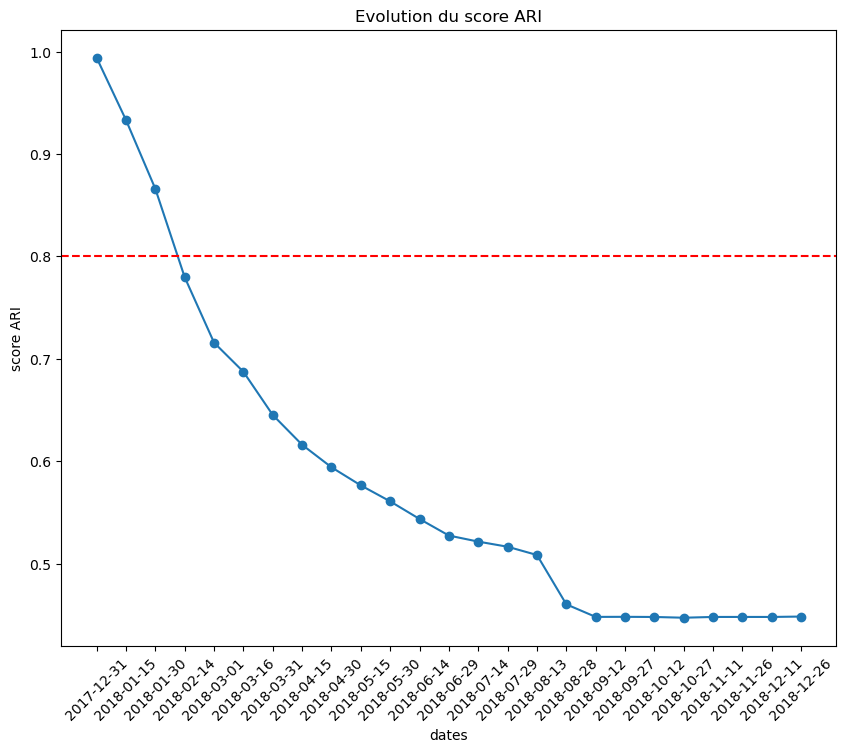

In [11]:
plt.figure(figsize = (10, 8))
plt.plot(dates, scores, marker = 'o')
plt.axhline(y = 0.8, color = 'red', linestyle='--')
plt.xlabel('dates')
plt.xticks(dates, rotation = 45)
plt.ylabel('score ARI')
plt.title('Evolution du score ARI')
plt.show()

Le score ARI descend en-dessous de 0.8 au bout de 45 jours. 